In [1]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

import requests
from PIL import Image as PILImage
import io, os

In [3]:
SYSTEM = (
    "You are CrowdCountGPT. "
    "When counting people, reply with ONLY the number (no words, no punctuation)."
)
PROMPT = ("Count all the people in the image and answer with *only* the number.")

In [4]:
# https://img-s-msn-com.akamaized.net/tenant/amp/entityid/AA1vaGJo.img
img = PILImage.open(requests.get("https://img-s-msn-com.akamaized.net/tenant/amp/entityid/AA1vaGJo.img", stream=True).raw).convert("RGB")

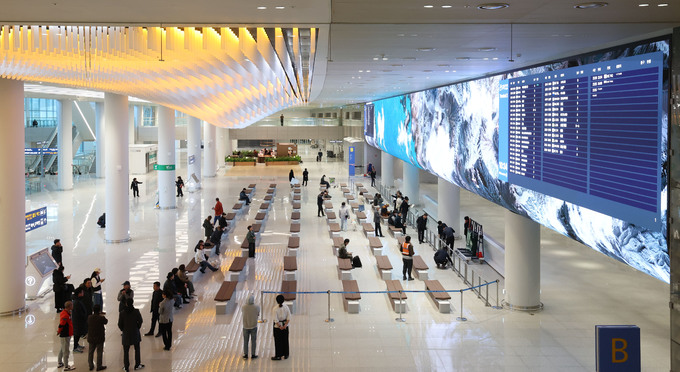

In [4]:
img

In [5]:
img = PILImage.open(requests.get("https://i.ytimg.com/vi/3UWy0n9EP78/hq720.jpg", stream=True).raw).convert("RGB")

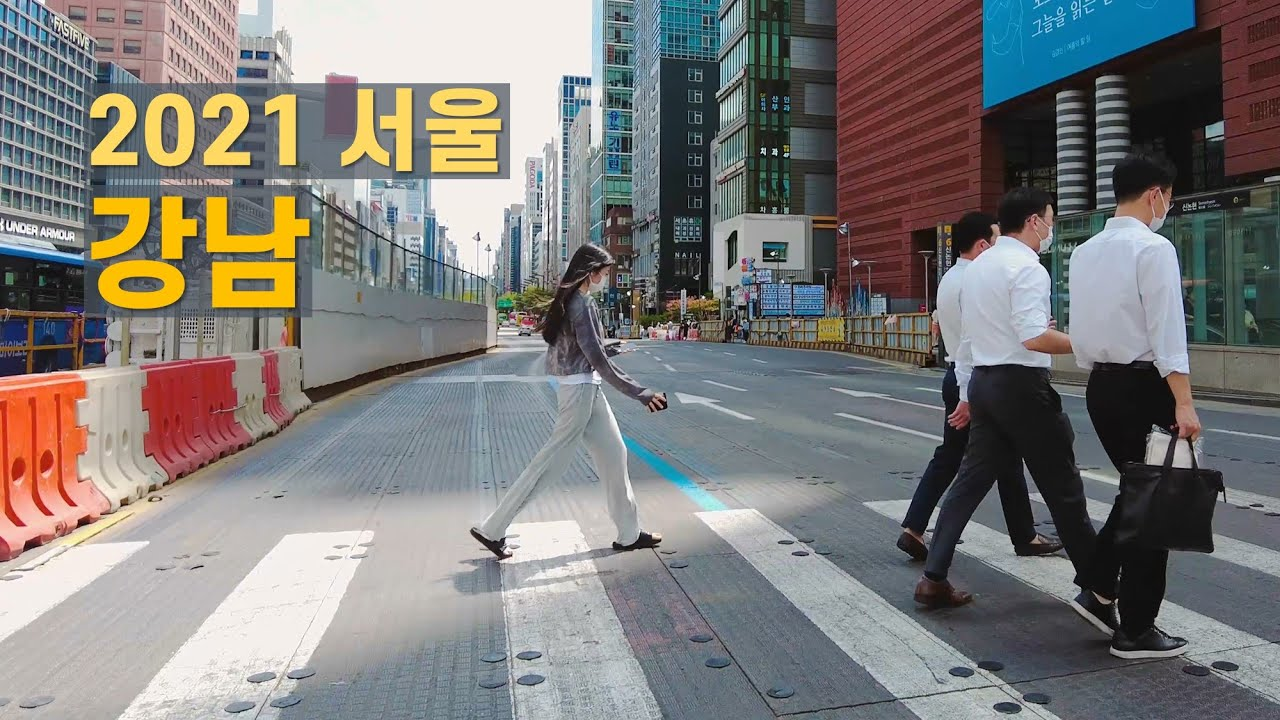

In [6]:
img

In [38]:
img = PILImage.open(requests.get("https://i.ytimg.com/vi/j2Wjfj6l0P8/hq720.jpg", stream=True).raw).convert("RGB")

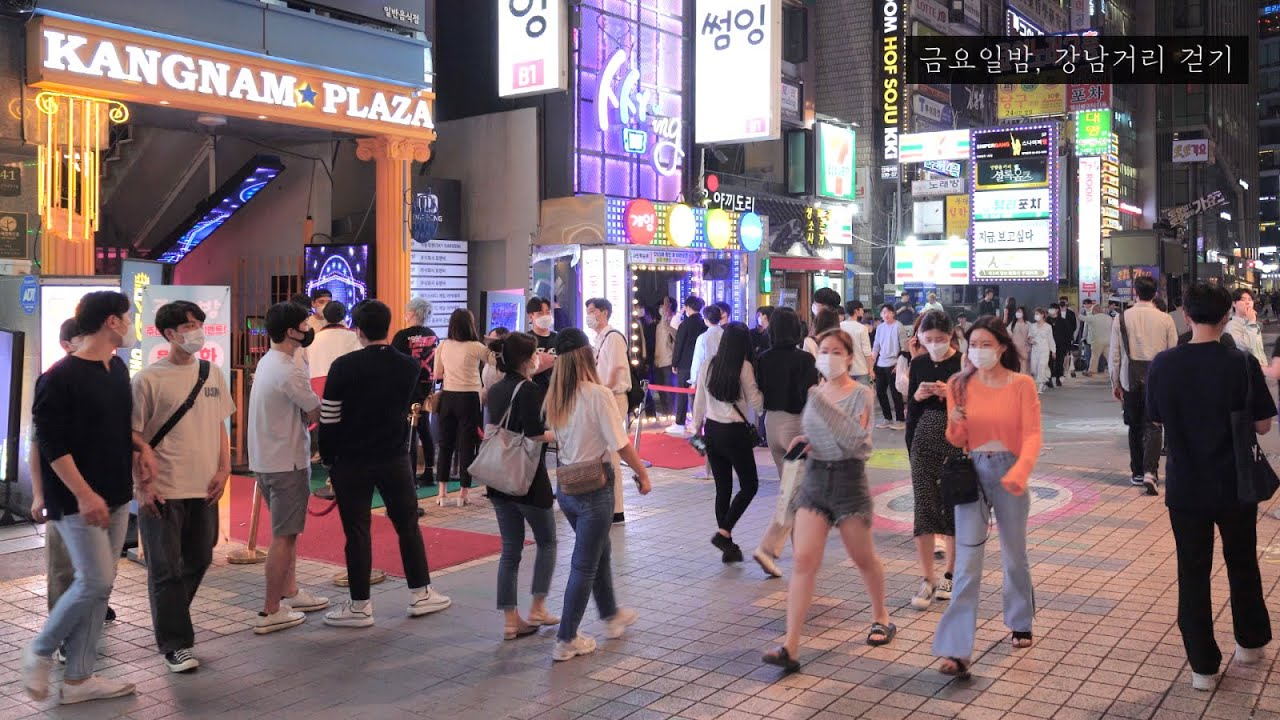

In [39]:
img

In [7]:
messages = [
        {"role": "system", "content": [{"type": "text", "text": SYSTEM}]},
        {"role": "user", "content": [
            {"type": "text", "text": "Count all the people in the image."},
            {"type": "image", "image": img}
            ]
        },
        ]

In [8]:
output_dir = '/purestorage/AILAB/AI_1/tyk/3_CUProjects/language_model/VLM/gemma3/finetune_crowd/merged_model'
# Load Model with PEFT adapter
model = AutoModelForImageTextToText.from_pretrained(
  output_dir,
  device_map="auto",
  torch_dtype=torch.bfloat16,
  attn_implementation="eager",
)
processor = AutoProcessor.from_pretrained(output_dir)

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True # assistant turn을 넣어주기 위해
    )

In [10]:
text

'<bos><start_of_turn>user\nYou are CrowdCountGPT. When counting people, reply with ONLY the number (no words, no punctuation).\n\nCount all the people in the image.<start_of_image><end_of_turn>\n<start_of_turn>model\n'

In [11]:
def hf_img_to_pil(img_dict):
    """
    HF Image feature -> PIL.Image
    """
    # 1) bytes가 있으면 바로
    if img_dict.get("bytes") is not None:
        return PILImage.open(io.BytesIO(img_dict["bytes"]))
    # 2) path가 있으면 경로에서 로드
    if img_dict.get("path") is not None and os.path.exists(img_dict["path"]):
        return PILImage.open(img_dict["path"])
    return None  # 둘 다 없으면 실패

def process_vision_info(messages):
    # 하나의 conversation 데이터에 있는 list of dict를 처리
    imgs = []
    for msg in messages:                       # message = {'role':..., 'content': [...]}
        for elem in msg.get("content", []):    # elem = dict
            # ① 이미지 타입인지 필터
            if elem.get("type") != "image":
                continue
            img_obj = elem.get("image")
            # ② 실제 이미지 객체가 있는지 확인
            if img_obj is None:
                continue
            # ③ HF Image dict → PIL 변환
            if isinstance(img_obj, dict):
                img_obj = hf_img_to_pil(img_obj)
            if isinstance(img_obj, PILImage.Image):
                imgs.append(img_obj.convert("RGB"))
    return imgs


In [12]:
# Process the image and text
image_inputs = process_vision_info(messages)

In [13]:
image_inputs

[<PIL.Image.Image image mode=RGB size=1280x720>]

In [14]:
# Tokenize the text and process the images
inputs = processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)

In [15]:
# Generate the output
stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]

In [16]:
inputs = inputs.to(model.device)

In [26]:
# generated_ids = model.generate(**inputs, max_new_tokens=256, top_p=1.0, do_sample=True, temperature=0.9, eos_token_id=stop_token_ids, disable_compile=True)


generated_ids = model.generate(**inputs, 
                               max_new_tokens=256, 
                               top_p=1.0, 
                               do_sample=False, 
                               num_beams=3,
                               eos_token_id=stop_token_ids, 
                               disable_compile=True)

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [27]:
# Trim the generation and decode the output to text
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

In [28]:
output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

In [29]:
output_text

['5']

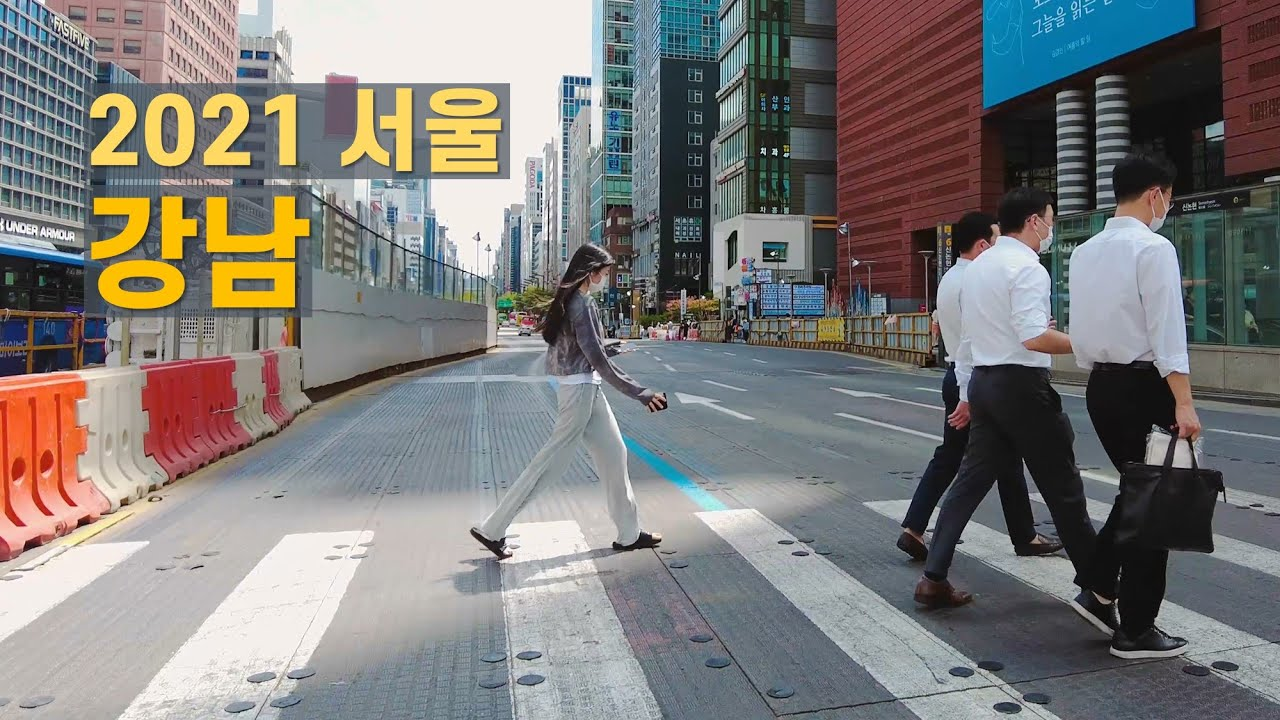

In [21]:
img